# Esperanza's Development Notebook - NEW Version

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import prophet as Prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
# Prophet import gives: "Importing plotly failed. Interactive plots will not work."
# Imported everything for Jupyter Notebook and plotly to cooperate but it still isn't

## Grabbing Data from Data/Out

In [2]:
# this path is based on my workflow with virtual environment - path will need to be changed

# floor_data = pd.read_csv('Capstone-Brick-Modeling/data/temp/combined_floors.csv')

In [18]:
#col_list = ['time', 'Common Setpoint', 'Actual Sup Flow SP', 'Zone Temperature', 'Actual Supply Flow', 'Outside Air Temp', 'Humidity', 'energy']

floor_2 = pd.read_csv('Capstone-Brick-Modeling/data/raw/merged_all_2F.csv', index_col = 'Unnamed: 0')
floor_3 = pd.read_csv('Capstone-Brick-Modeling/data/raw/merged_all_3F.csv', index_col = 'Unnamed: 0')
floor_4 = pd.read_csv('Capstone-Brick-Modeling/data/raw/merged_all_4F.csv', index_col = 'Unnamed: 0')

In [19]:
# one version of this is Unnamed: 0.2 but I'm not sure why this one says 

floor_2 = floor_2.drop(['Unnamed: 0.1.1'], axis = 1)

In [20]:
floor_2.head(5)

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,0,2018-01-03T20:57:39+00:00,72.5,330.0,75.2,318.73,10.109642,68.44,56.0,75.2,317.06,68.50,56.0,10.113301
1,1,2018-01-03T21:04:13+00:00,72.5,330.0,75.2,317.06,10.113301,68.50,56.0,75.7,314.34,68.25,56.0,10.099466
2,2,2018-01-03T21:10:44+00:00,72.5,330.0,75.7,314.34,10.099466,68.25,56.0,75.7,313.91,68.31,56.0,10.241028
3,3,2018-01-03T21:17:16+00:00,72.5,330.0,75.7,313.91,10.241028,68.31,56.0,75.7,318.31,68.44,57.0,10.187620
4,4,2018-01-03T21:23:44+00:00,72.5,330.0,75.7,318.31,10.187620,68.44,57.0,75.7,316.65,68.81,57.0,10.194055


In [21]:
floor_2['time_transformed'] = pd.to_datetime(floor_2['time'])
floor_2['time_floored'] = floor_2['time_transformed'].transform(lambda x: x.floor(freq='5T'))
floor_2['unix_floored'] = floor_2['time_floored'].view('int64')

In [22]:
floor_2['time_floored'].value_counts()

2017-07-09 07:00:00+00:00    12
2017-07-13 07:35:00+00:00    12
2017-07-09 20:50:00+00:00    12
2017-07-30 22:05:00+00:00    12
2017-07-10 18:00:00+00:00    12
                             ..
2017-07-18 07:00:00+00:00     3
2017-07-18 04:45:00+00:00     3
2017-07-18 17:45:00+00:00     3
2017-09-15 10:05:00+00:00     2
2017-09-15 09:55:00+00:00     2
Name: time_floored, Length: 45597, dtype: int64

In [27]:
floor_2.groupby(['time_floored', 'Unnamed: 0.1']).count()['time']

time_floored               Unnamed: 0.1
2017-07-07 13:35:00+00:00  0               6
2017-07-07 13:40:00+00:00  1               6
2017-07-07 13:45:00+00:00  2               6
2017-07-07 13:55:00+00:00  3               6
2017-07-07 14:00:00+00:00  4               6
                                          ..
2018-02-20 18:15:00+00:00  206             5
2018-02-20 18:40:00+00:00  207             3
2018-02-20 19:05:00+00:00  208             3
2018-02-20 19:30:00+00:00  209             5
2018-02-20 19:55:00+00:00  210             4
Name: time, Length: 45835, dtype: int64

In [26]:
floor_2.groupby(['time_floored', 'Unnamed: 0.1']).count()['time'].max()

6

In [28]:
floor_2.groupby(['time_floored', 'Unnamed: 0.1']).count()['time'].min()

2

In [ ]:
# identify rooms - row based or using the next values???
# --> try 
# try with sums instead -- impute next missing values

# try to run 

# 

In [ ]:
# round it either floor or higher consistently for timestamps --> explain assumption

# transform to unix timestamp*** check with prophet compatibility

#

In [29]:
#floor_3 = floor_3.drop(['Unnamed: 0.1'], axis = 1)

In [30]:
floor_3.head(5)

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,0,2018-07-05T00:58:48+00:00,72.0,295.0,73.75,287.56,9.067059,68.88,53.0,73.75,289.97,69.31,53.0,9.104582
1,1,2018-07-05T01:04:13+00:00,72.0,295.0,73.75,289.97,9.104582,69.31,53.0,73.75,291.17,68.88,53.0,9.377247
2,2,2018-07-05T01:09:37+00:00,72.0,295.0,73.75,291.17,9.377247,68.88,53.0,73.75,299.89,68.94,53.0,9.147068
3,3,2018-07-05T01:15:17+00:00,72.0,295.0,73.75,299.89,9.147068,68.94,53.0,73.75,294.97,69.13,53.0,9.198235
4,4,2018-07-05T01:20:55+00:00,72.0,295.0,73.75,294.97,9.198235,69.13,53.0,73.75,296.62,68.94,53.0,9.212810


In [31]:
floor_3['time_transformed'] = pd.to_datetime(floor_3['time'])
floor_3['time_floored'] = floor_3['time_transformed'].transform(lambda x: x.floor(freq='5T'))
floor_3['unix_floored'] = floor_3['time_floored'].view('int64')

In [32]:
floor_3['time_floored'].value_counts()

2017-11-05 09:50:00+00:00    8
2018-11-18 06:15:00+00:00    8
2018-11-18 05:30:00+00:00    8
2017-11-21 13:35:00+00:00    4
2018-09-23 04:30:00+00:00    4
                            ..
2017-10-12 22:35:00+00:00    3
2017-10-11 11:55:00+00:00    3
2017-10-11 04:55:00+00:00    3
2018-11-19 00:00:00+00:00    1
2018-11-18 23:50:00+00:00    1
Name: time_floored, Length: 48477, dtype: int64

In [33]:
floor_3.groupby(['time_floored', 'Unnamed: 0.1']).count()['time']

time_floored               Unnamed: 0.1
2017-10-11 01:00:00+00:00  0               3
2017-10-11 01:05:00+00:00  1               3
2017-10-11 01:10:00+00:00  2               3
2017-10-11 01:20:00+00:00  3               3
2017-10-11 01:25:00+00:00  4               3
                                          ..
2019-01-03 01:10:00+00:00  408             4
2019-01-03 01:15:00+00:00  409             4
2019-01-03 01:20:00+00:00  410             4
2019-01-03 01:30:00+00:00  411             4
2019-01-03 01:35:00+00:00  412             4
Name: time, Length: 48480, dtype: int64

In [34]:
floor_3.groupby(['time_floored', 'Unnamed: 0.1']).count()['time'].max()

4

In [35]:
floor_3.groupby(['time_floored', 'Unnamed: 0.1']).count()['time'].min()

1

In [ ]:
# 4 rooms on floor 3

In [ ]:
# 8 rooms in the pool? what's going on

In [ ]:
# let me try building 3 different models based on floors instead of using the whole combned thing

In [36]:
#floor_4 = floor_4.drop(['Unnamed: 0.1'], axis = 1)

In [37]:
floor_4.head(5)

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next
0,0,2018-09-23T22:59:39+00:00,72.0,722.73,75.25,733.46,23.554224,71.31,53.0,74.74,692.03,71.19,53.0,22.261861
1,1,2018-09-23T23:06:38+00:00,72.0,661.39,74.74,692.03,22.261861,71.19,53.0,74.74,654.06,71.19,53.0,19.471076
2,2,2018-09-23T23:13:38+00:00,72.0,624.95,74.74,654.06,19.471076,71.19,53.0,74.24,576.94,70.94,53.0,18.861571
3,3,2018-09-23T23:20:38+00:00,72.0,562.05,74.24,576.94,18.861571,70.94,53.0,74.24,558.88,70.94,53.0,17.087055
4,4,2018-09-23T23:27:37+00:00,72.0,532.93,74.24,558.88,17.087055,70.94,53.0,74.24,506.30,70.81,53.0,16.212959


In [38]:
floor_4['time_transformed'] = pd.to_datetime(floor_4['time'])
floor_4['time_floored'] = floor_4['time_transformed'].transform(lambda x: x.floor(freq='5T'))
floor_4['unix_floored'] = floor_4['time_floored'].view('int64')

In [39]:
floor_4['time_floored'].value_counts()

2018-12-15 21:50:00+00:00    5
2018-12-03 20:30:00+00:00    5
2018-06-16 05:40:00+00:00    5
2018-11-05 23:15:00+00:00    5
2018-11-08 05:00:00+00:00    5
                            ..
2017-12-21 16:00:00+00:00    3
2017-12-21 11:30:00+00:00    3
2017-12-21 03:35:00+00:00    3
2018-10-07 20:35:00+00:00    2
2018-10-07 20:45:00+00:00    2
Name: time_floored, Length: 34559, dtype: int64

In [ ]:
# floor 4 is more regular but it's hard to tell what's going on here

In [40]:
floor_4.groupby(['time_floored', 'Unnamed: 0.1']).count()['time']

time_floored               Unnamed: 0.1
2017-12-21 00:05:00+00:00  0               3
2017-12-21 00:10:00+00:00  1               3
2017-12-21 00:15:00+00:00  2               3
2017-12-21 00:25:00+00:00  3               3
2017-12-21 00:30:00+00:00  4               3
                                          ..
2019-01-07 23:10:00+00:00  347             5
2019-01-07 23:15:00+00:00  348             5
2019-01-07 23:25:00+00:00  349             5
2019-01-07 23:30:00+00:00  350             5
2019-01-07 23:35:00+00:00  351             5
Name: time, Length: 34559, dtype: int64

In [41]:
floor_4.groupby(['time_floored', 'Unnamed: 0.1']).count()['time'].max()

5

In [42]:
floor_4.groupby(['time_floored', 'Unnamed: 0.1']).count()['time'].min()

2

In [ ]:
# 5 rooms on floor 4, 4 on floor 3, 6 on floor 2
# how is it worth doing averages here?
# do we try and impute with the mean value for the floor and the timestamp?
# doesn't fix the issue that the main time data is different

In [ ]:
# I'm going to impute with the combined groups and then just 

In [43]:
floor_2['floor'] = 2
floor_3['floor'] = 3
floor_4['floor'] = 4

In [44]:
# ignoring Will's zone number code

combined_floors = pd.concat([floor_2, floor_3, floor_4]).reset_index(drop = True)


In [45]:
combined_floors.head(5)

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored,unix_floored,floor
0,0,2018-01-03T20:57:39+00:00,72.5,330.0,75.2,318.73,10.109642,68.44,56.0,75.2,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2
1,1,2018-01-03T21:04:13+00:00,72.5,330.0,75.2,317.06,10.113301,68.50,56.0,75.7,314.34,68.25,56.0,10.099466,2018-01-03 21:04:13+00:00,2018-01-03 21:00:00+00:00,1515013200000000000,2
2,2,2018-01-03T21:10:44+00:00,72.5,330.0,75.7,314.34,10.099466,68.25,56.0,75.7,313.91,68.31,56.0,10.241028,2018-01-03 21:10:44+00:00,2018-01-03 21:10:00+00:00,1515013800000000000,2
3,3,2018-01-03T21:17:16+00:00,72.5,330.0,75.7,313.91,10.241028,68.31,56.0,75.7,318.31,68.44,57.0,10.187620,2018-01-03 21:17:16+00:00,2018-01-03 21:15:00+00:00,1515014100000000000,2
4,4,2018-01-03T21:23:44+00:00,72.5,330.0,75.7,318.31,10.187620,68.44,57.0,75.7,316.65,68.81,57.0,10.194055,2018-01-03 21:23:44+00:00,2018-01-03 21:20:00+00:00,1515014400000000000,2


In [98]:
mean_energy = combined_floors.groupby(['time_floored', 'Unnamed: 0.1']).mean()['energy']

In [51]:
counts = combined_floors.groupby(['time_floored', 'Unnamed: 0.1']).count()['energy'].rename('counts')

In [68]:
counts.to_frame()

time_floored               Unnamed: 0.1
2017-07-07 13:35:00+00:00  0               6
2017-07-07 13:40:00+00:00  1               6
2017-07-07 13:45:00+00:00  2               6
2017-07-07 13:55:00+00:00  3               6
2017-07-07 14:00:00+00:00  4               6
                                          ..
2019-01-07 23:10:00+00:00  347             5
2019-01-07 23:15:00+00:00  348             5
2019-01-07 23:25:00+00:00  349             5
2019-01-07 23:30:00+00:00  350             5
2019-01-07 23:35:00+00:00  351             5
Name: counts, Length: 128799, dtype: int64

In [96]:
need_more_vals = 6 - counts[6 - counts > 0].to_frame()

In [100]:
need_more_vals.shape

(93327, 1)

In [101]:
merged_duplicates = need_more_vals.merge(mean_energy.to_frame(), left_index = True, right_index = True)

In [112]:
group_1 = merged_duplicates.reset_index().drop(['counts'], axis = 1)

In [106]:
group_2 = merged_duplicates.loc[merged_duplicates['counts'] >= 2].reset_index().drop(['counts'], axis = 1)
group_3 = merged_duplicates.loc[merged_duplicates['counts'] >= 3].reset_index().drop(['counts'], axis = 1)
group_4 = merged_duplicates.loc[merged_duplicates['counts'] >= 4].reset_index().drop(['counts'], axis = 1)
group_5 = merged_duplicates.loc[merged_duplicates['counts'] == 5].reset_index().drop(['counts'], axis = 1)

In [113]:
relevant_vals = combined_floors.loc[:, ['time_floored', 'energy', 'Unnamed: 0.1']]

In [115]:
total_group = pd.concat([relevant_vals, group_1, group_2, group_3, group_4, group_5])

In [125]:
counts.to_frame().value_counts()

counts
4         51673
5         40487
6         35397
3          1161
9            75
2             4
1             2
dtype: int64

In [123]:
relevant_vals.shape

(625677, 3)

In [124]:
group_1.shape

(93327, 3)

In [116]:
total_group.shape

(773019, 4)

In [122]:
total_group.groupby(['time_floored', 'Unnamed: 0.1']).count()['energy'].value_counts()

6    75884
5    51673
4     1161
9       75
3        4
2        2
Name: energy, dtype: int64

In [50]:
combined_floors.groupby(['time_floored', 'Unnamed: 0.1']).count()['energy'].min()

1

In [ ]:
# so the question is do we fill this up to 6 with the mean value and see what that does

In [53]:
combined_merge = combined_floors.merge(counts.to_frame(), left_on = ['time_floored', 'Unnamed: 0.1'], right_index = True)

In [54]:
combined_merge.head()

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored,unix_floored,floor,counts
0,0,2018-01-03T20:57:39+00:00,72.5,330.00,75.20,318.73,10.109642,68.44,56.0,75.20,317.06,68.5,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
9170,0,2018-01-03T20:57:39+00:00,72.0,478.99,73.75,480.73,15.784821,68.44,56.0,73.75,508.34,68.5,56.0,16.453675,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
16178,0,2018-01-03T20:57:39+00:00,72.0,215.00,70.87,217.02,6.311495,68.44,56.0,70.87,214.71,68.5,56.0,6.103669,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
62260,0,2018-01-03T20:57:39+00:00,71.5,594.86,72.21,569.24,22.509782,68.44,56.0,72.71,739.15,68.5,56.0,25.988802,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
82176,0,2018-01-03T20:57:39+00:00,72.0,295.00,72.29,293.29,8.902075,68.44,56.0,72.80,291.82,68.5,56.0,8.924649,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6


In [71]:
timestamp_df = counts.to_frame()

In [73]:
df_ver6 = pd.concat([timestamp_df] * 6).reset_index()

In [74]:
df_ver6.head()

,time_floored,Unnamed: 0.1,counts
0,2017-07-07 13:35:00+00:00,0,6
1,2017-07-07 13:40:00+00:00,1,6
2,2017-07-07 13:45:00+00:00,2,6
3,2017-07-07 13:55:00+00:00,3,6
4,2017-07-07 14:00:00+00:00,4,6


In [77]:
df_ver6.shape

(772794, 3)

In [86]:
combined_merge_2 = combined_floors.merge(df_ver6, how = 'outer', left_on = ['time_floored', 'Unnamed: 0.1'], right_on = ['time_floored', 'Unnamed: 0.1'])

In [87]:
combined_merge_2

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored,unix_floored,floor,counts
0,0,2018-01-03T20:57:39+00:00,72.5,330.00,75.20,318.73,10.109642,68.44,56.0,75.20,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
1,0,2018-01-03T20:57:39+00:00,72.5,330.00,75.20,318.73,10.109642,68.44,56.0,75.20,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
2,0,2018-01-03T20:57:39+00:00,72.5,330.00,75.20,318.73,10.109642,68.44,56.0,75.20,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
3,0,2018-01-03T20:57:39+00:00,72.5,330.00,75.20,318.73,10.109642,68.44,56.0,75.20,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
4,0,2018-01-03T20:57:39+00:00,72.5,330.00,75.20,318.73,10.109642,68.44,56.0,75.20,317.06,68.50,56.0,10.113301,2018-01-03 20:57:39+00:00,2018-01-03 20:55:00+00:00,1515012900000000000,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754057,403,2018-09-13T22:42:00+00:00,72.5,375.05,73.88,369.77,12.201436,73.06,55.0,73.88,362.80,73.06,55.0,10.884434,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5
3754058,403,2018-09-13T22:42:00+00:00,72.5,375.05,73.88,369.77,12.201436,73.06,55.0,73.88,362.80,73.06,55.0,10.884434,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5
3754059,403,2018-09-13T22:42:00+00:00,72.5,375.05,73.88,369.77,12.201436,73.06,55.0,73.88,362.80,73.06,55.0,10.884434,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5
3754060,403,2018-09-13T22:42:00+00:00,72.5,375.05,73.88,369.77,12.201436,73.06,55.0,73.88,362.80,73.06,55.0,10.884434,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5


In [90]:
combined_merge_2['energy'].isna().sum()

0

In [79]:
combined_merge_2.drop_duplicates().shape

(625658, 19)

In [55]:
combined_merge.shape

(625677, 19)

In [56]:
combined_merge[combined_merge['counts'] < 6]

,Unnamed: 0.1,time,Common Setpoint,Actual Sup Flow SP,Zone Temperature,Actual Supply Flow,energy,Outside Air Temp,Humidity,Zone Temperature Next,Actual Supply Flow Next,Outside Air Temp Next,Humidity Next,energy Next,time_transformed,time_floored,unix_floored,floor,counts
10236,193,2017-12-15T19:21:48+00:00,72.0,1085.00,75.30,1091.93,33.992395,71.31,39.0,74.79,1050.89,69.81,38.0,35.343752,2017-12-15 19:21:48+00:00,2017-12-15 19:20:00+00:00,1513365600000000000,2,5
26325,193,2017-12-15T19:21:48+00:00,72.0,215.00,70.82,229.14,6.573315,71.31,39.0,70.82,218.65,69.81,38.0,6.544154,2017-12-15 19:21:48+00:00,2017-12-15 19:20:00+00:00,1513365600000000000,2,5
77408,193,2017-12-15T19:21:48+00:00,68.0,1085.00,71.31,1094.79,32.574119,71.31,39.0,71.31,1073.46,69.81,38.0,33.428703,2017-12-15 19:21:48+00:00,2017-12-15 19:20:00+00:00,1513365600000000000,2,5
99526,193,2017-12-15T19:21:48+00:00,72.0,844.71,73.29,818.04,27.898927,71.31,39.0,73.29,886.14,69.81,38.0,31.034745,2017-12-15 19:21:48+00:00,2017-12-15 19:20:00+00:00,1513365600000000000,2,5
136093,193,2017-12-15T19:21:48+00:00,72.0,331.71,74.60,352.76,11.915772,71.31,39.0,74.60,369.63,69.81,38.0,15.267684,2017-12-15 19:21:48+00:00,2017-12-15 19:20:00+00:00,1513365600000000000,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567584,403,2018-09-13T22:42:00+00:00,72.0,361.09,74.68,389.53,12.236417,73.06,55.0,74.68,358.93,73.06,55.0,12.046187,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5
590424,403,2018-09-13T22:42:00+00:00,73.5,310.00,76.27,313.98,11.087377,73.06,55.0,76.27,316.73,73.06,55.0,11.007213,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5
594088,403,2018-09-13T22:42:00+00:00,73.0,310.00,74.58,318.01,10.837744,73.06,55.0,74.58,318.44,73.06,55.0,10.830256,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5
599036,403,2018-09-13T22:42:00+00:00,70.5,310.00,73.39,346.13,10.614814,73.06,55.0,73.39,318.29,73.06,55.0,11.605628,2018-09-13 22:42:00+00:00,2018-09-13 22:40:00+00:00,1536878400000000000,4,5


In [ ]:
# need 

In [27]:
combined_floors['time_transformed'] = pd.to_datetime(combined_floors['time'])

In [31]:
# https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.floor.html
combined_floors['ts_floored'] = combined_floors['time_transformed'].transform(lambda x: x.floor(freq='5T'))

In [33]:
combined_floors['unix_floored'] = combined_floors['ts_floored'].view('int64')

In [39]:
combined_floors['ts_floored'].value_counts(ascending = True)[0:10]

2018-11-19 00:00:00+00:00    1
2018-11-18 23:50:00+00:00    1
2017-09-15 09:55:00+00:00    2
2018-10-07 20:45:00+00:00    2
2017-09-15 10:05:00+00:00    2
2018-10-07 20:35:00+00:00    2
2017-07-18 09:50:00+00:00    3
2017-07-18 16:20:00+00:00    3
2017-07-18 02:25:00+00:00    3
2017-07-18 16:10:00+00:00    3
Name: ts_floored, dtype: int64

In [ ]:
# I think to better impute missing timestamps, we'll want to floor values to 5 minutes in each floor
# Then find out what timestamps are under represented there?

## Getting Relevant Dates for Train / Test Data

In [14]:
dates = combined_floors['time_transformed'].transform(lambda x: x.date)

In [15]:
dates_test = (dates >= pd.Timestamp('2018-08-01'))

In [16]:
onwards_test_date = combined_floors.loc[dates_test, :]
pre_test_date = combined_floors.loc[~dates_test, :]

In [17]:
pre_test_date.shape

(437044, 15)

In [18]:
onwards_test_date.shape

(188633, 15)

In [19]:
# amount of data in test set: 30%
188633 / (188633 + 437044)

0.3014862301155388

## Work with Prophet

#### For missing analysis work, please look at old version of this notebook.

In [20]:
# choosing the relevant info
pre_test_date_reduced = pre_test_date.loc[:, ['time', 'energy']].reset_index(drop = True)
onwards_test_date_reduced = onwards_test_date.loc[:, ['time', 'energy']].reset_index(drop = True)

In [21]:
# stripping time zones since they're incompatible with Prophet
pre_test_date_reduced['time'] = pre_test_date_reduced['time'].transform(lambda x: x[0:-6])
onwards_test_date_reduced['time'] = onwards_test_date_reduced['time'].transform(lambda x: x[0:-6])

In [22]:
pre_test_date_reduced = pre_test_date_reduced.rename({'time': 'ds', 'energy': 'y'}, axis = 1)
onwards_test_date_reduced = onwards_test_date_reduced.rename({'time': 'ds', 'energy': 'y'}, axis = 1)


### Determining cap for Prophet model

In [23]:
pre_test_date_reduced['y'].sort_values(ascending = False)

145445    49.165584
76149     48.547559
145444    46.165827
321162    44.646128
76148     44.415555
            ...    
313991     0.000000
313992     0.000000
313993     0.000000
313995     0.000000
118362     0.000000
Name: y, Length: 437044, dtype: float64

In [25]:
pre_test_date_reduced['y'].mean()

9.600232685687184

In [26]:
pre_test_date_reduced['y'].median()

9.078714640036456

In [27]:
pre_test_date_reduced['cap'] = 50
# have not set a changing cap with HVAC because I'm not sure it did change over this time frame

### Training Model

In [28]:
prophet_model = Prophet.Prophet()

In [29]:
prophet_model.fit(pre_test_date_reduced)
# got disabling yearly seasonality text - I think this makes sense to disable because our data < year

17:14:54 - cmdstanpy - INFO - Chain [1] start processing
17:16:51 - cmdstanpy - INFO - Chain [1] done processing


### Making Model Forecast

#### We want to predict every 5 minutes from August 2, 2018 through the end of the data on January 7?, 2019
This involves 5 minutes ... still figuring this out

In [30]:
prophet_forecast = prophet_model.make_future_dataframe(periods = 51000, freq = '5min')
prophet_forecast = prophet_model.predict(prophet_forecast)


In [31]:
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
107475,2019-01-08 23:17:40,20.980550,-162.284132,199.078971,-166.121961,194.614032,4.356247,4.356247,4.356247,3.606161,3.606161,3.606161,0.750086,0.750086,0.750086,0.0,0.0,0.0,25.336797
107476,2019-01-08 23:22:40,20.980764,-161.422259,200.722969,-166.124549,194.621677,4.283452,4.283452,4.283452,3.533172,3.533172,3.533172,0.750280,0.750280,0.750280,0.0,0.0,0.0,25.264215
107477,2019-01-08 23:27:40,20.980977,-165.696544,204.387464,-166.127136,194.629322,4.212310,4.212310,4.212310,3.461816,3.461816,3.461816,0.750494,0.750494,0.750494,0.0,0.0,0.0,25.193286
107478,2019-01-08 23:32:40,20.981190,-161.750799,199.679502,-166.129723,194.636967,4.142886,4.142886,4.142886,3.392158,3.392158,3.392158,0.750728,0.750728,0.750728,0.0,0.0,0.0,25.124076
107479,2019-01-08 23:37:40,20.981403,-164.303254,200.072152,-166.132310,194.644612,4.075226,4.075226,4.075226,3.324244,3.324244,3.324244,0.750982,0.750982,0.750982,0.0,0.0,0.0,25.056629


In [ ]:
# This got us a little past the time I wanted to be at but it works

## Plot Analysis

#### Initial result shows that y hat values grow too quickly

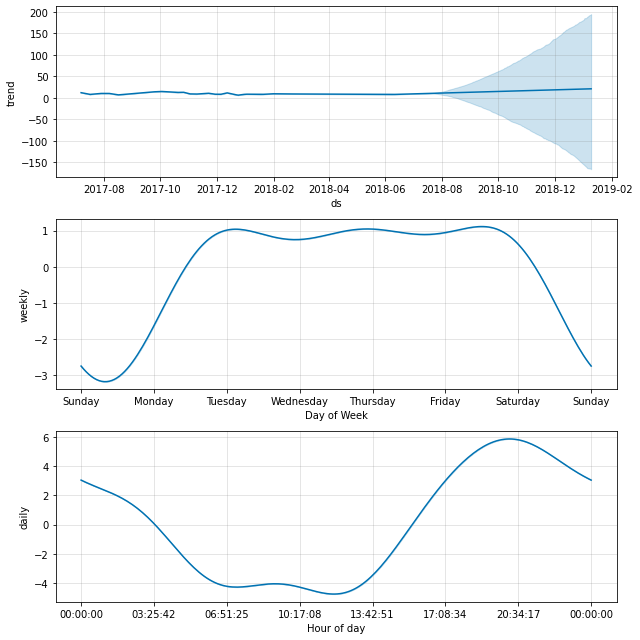

In [32]:
fig2 = prophet_model.plot_components(prophet_forecast)

In [ ]:
# Ok it seems to follow what we expect for the weekends but may not follow what we're expecting for the other two


In [35]:
prophet_forecast_reduced = prophet_forecast.loc[:, ['ds', 'yhat']]

In [36]:
prophet_forecast_reduced['timestamp_changed'] = prophet_forecast_reduced['ds'].transform(lambda x: pd.Timestamp(x))

In [37]:
#onwards_compare = onwards_test_date.loc[:, ['time', 'energy']]
#onwards_compare['time'] = onwards_compare['time'].transform(lambda x: x[0:-6])
#onwards_compare = onwards_compare.rename({'time': 'ds', 'energy': 'yhat'}, axis = 1)
onwards_test_date_reduced['timestamp_changed'] = onwards_test_date_reduced['ds'].transform(lambda x: pd.Timestamp(x))

In [38]:
onwards_test_date_reduced.head(5)

,ds,y,timestamp_changed
0,2018-09-03T01:02:18,9.038064,2018-09-03 01:02:18
1,2018-09-03T01:09:23,9.020124,2018-09-03 01:09:23
2,2018-09-03T01:16:28,8.966305,2018-09-03 01:16:28
3,2018-09-03T01:23:32,9.121355,2018-09-03 01:23:32
4,2018-09-03T01:30:36,8.978479,2018-09-03 01:30:36


In [39]:
onwards_test_date_reduced.shape

(188633, 3)

In [40]:
pre_test_date_reduced.shape

(437044, 3)

In [41]:
merge_test = prophet_forecast_reduced.merge(onwards_test_date_reduced, left_on = 'timestamp_changed', right_on = 'timestamp_changed')

In [42]:
merge_test

,ds_x,yhat,timestamp_changed,ds_y,y
0,2018-08-19 23:47:40,13.798828,2018-08-19 23:47:40,2018-08-19T23:47:40,9.840562
1,2018-08-19 23:47:40,13.798828,2018-08-19 23:47:40,2018-08-19T23:47:40,30.443329
2,2018-08-19 23:47:40,13.798828,2018-08-19 23:47:40,2018-08-19T23:47:40,14.192031
3,2018-08-19 23:47:40,13.798828,2018-08-19 23:47:40,2018-08-19T23:47:40,9.711402
4,2018-08-19 23:47:40,13.798828,2018-08-19 23:47:40,2018-08-19T23:47:40,2.587140
...,...,...,...,...,...
666,2019-01-03 13:52:40,18.339066,2019-01-03 13:52:40,2019-01-03T13:52:40,0.000000
667,2019-01-03 13:52:40,18.339066,2019-01-03 13:52:40,2019-01-03T13:52:40,1.082106
668,2019-01-03 13:52:40,18.339066,2019-01-03 13:52:40,2019-01-03T13:52:40,1.110293
669,2019-01-03 13:52:40,18.339066,2019-01-03 13:52:40,2019-01-03T13:52:40,10.899280


In [43]:
merge_test['yhat'].nunique() # there's only 77 unique valhyes

77

In [44]:
no_duplicates = merge_test.drop_duplicates(subset=['ds_x', 'yhat'], keep = 'first')

,ds_x,yhat,timestamp_changed,ds_y,y
0,2018-08-19 23:47:40,13.798828,2018-08-19 23:47:40,2018-08-19T23:47:40,9.840562
9,2018-08-22 22:22:40,17.969757,2018-08-22 22:22:40,2018-08-22T22:22:40,17.506711
18,2018-08-24 06:37:40,9.460525,2018-08-24 06:37:40,2018-08-24T06:37:40,0.000000
27,2018-08-24 21:17:40,18.827332,2018-08-24 21:17:40,2018-08-24T21:17:40,9.595517
36,2018-08-26 12:57:40,5.360984,2018-08-26 12:57:40,2018-08-26T12:57:40,10.053308
...,...,...,...,...,...
634,2019-01-02 01:42:40,23.286857,2019-01-02 01:42:40,2019-01-02T01:42:40,9.363716
643,2019-01-02 10:32:40,17.127351,2019-01-02 10:32:40,2019-01-02T10:32:40,0.000000
652,2019-01-02 17:52:40,25.764684,2019-01-02 17:52:40,2019-01-02T17:52:40,9.487824
661,2019-01-03 05:32:40,18.387584,2019-01-03 05:32:40,2019-01-03T05:32:40,10.397932


In [48]:
onwards_test_date_reduced.loc[onwards_test_date_reduced['timestamp_changed'] == pd.Timestamp('2018-08-19T23:47:40')]

,ds,y,timestamp_changed
11475,2018-08-19T23:47:40,9.840562,2018-08-19 23:47:40
11897,2018-08-19T23:47:40,30.443329,2018-08-19 23:47:40
29696,2018-08-19T23:47:40,14.192031,2018-08-19 23:47:40
50045,2018-08-19T23:47:40,9.711402,2018-08-19 23:47:40
90470,2018-08-19T23:47:40,2.587140,2018-08-19 23:47:40
117234,2018-08-19T23:47:40,1.100667,2018-08-19 23:47:40
156223,2018-08-19T23:47:40,0.803533,2018-08-19 23:47:40
168649,2018-08-19T23:47:40,10.666441,2018-08-19 23:47:40
171139,2018-08-19T23:47:40,20.133840,2018-08-19 23:47:40


In [ ]:
# this dataset introduces duplicate measurements from each of the floors but it also has multiple duplicates

# per floor -- should we train on each or how should we do this?

In [ ]:
# I'm very confused why there's duplicates here??? Need to clear these up and see which y values are causing this

# Attempt # 2

In [31]:
floor_2_reduced = floor_2.loc[:, ['time', 'energy']].rename({'time': 'ds', 'energy': 'y'}, axis = 1)

In [32]:
floor_2_reduced['ds'] = floor_2_reduced['ds'].str[0:-6]

In [33]:
floor_2_reduced['time_transformed'] = floor_2_reduced['ds'].transform(pd.Timestamp)

In [34]:
shape_val = floor_2_reduced['time_transformed'].shape[0]

In [35]:
np.round(((0.70) * shape_val))

182172.0

In [36]:
seventy_front = floor_2_reduced.sort_values(by='time_transformed')[0:int(np.round(((0.70) * shape_val)))]
thirty_back = floor_2_reduced.sort_values(by='time_transformed')[int(np.round(((0.70) * shape_val))):]

In [37]:
seventy_front_red = seventy_front.drop(['time_transformed'], axis = 1)
thirty_back_red = thirty_back.drop(['time_transformed'], axis = 1)


In [63]:
thirty_back.head()

,ds,y,time_transformed
81835,2017-12-19T07:09:19,9.359546,2017-12-19 07:09:19
43947,2017-12-19T07:09:19,8.980292,2017-12-19 07:09:19
107828,2017-12-19T07:09:19,1.403920,2017-12-19 07:09:19
124032,2017-12-19T07:09:19,1.919384,2017-12-19 07:09:19
193314,2017-12-19T07:16:00,0.809618,2017-12-19 07:16:00


In [38]:
prophet_model = Prophet.Prophet()

In [39]:
prophet_model.fit(seventy_front_red)


17:18:21 - cmdstanpy - INFO - Chain [1] start processing
17:18:58 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
prophet_forecast = prophet_model.make_future_dataframe(periods = 51000, freq = '5min')
prophet_forecast = prophet_model.predict(prophet_forecast)

In [41]:
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
83789,2018-06-14 08:49:19,7.253783,-177.723559,207.867958,-176.433270,215.436949,-3.386836,-3.386836,-3.386836,-4.071788,-4.071788,-4.071788,0.684951,0.684951,0.684951,0.0,0.0,0.0,3.866947
83790,2018-06-14 08:54:19,7.253740,-182.552229,212.736532,-176.438299,215.442119,-3.370876,-3.370876,-3.370876,-4.054194,-4.054194,-4.054194,0.683317,0.683317,0.683317,0.0,0.0,0.0,3.882864
83791,2018-06-14 08:59:19,7.253698,-180.011846,214.683009,-176.443328,215.447289,-3.357380,-3.357380,-3.357380,-4.039056,-4.039056,-4.039056,0.681675,0.681675,0.681675,0.0,0.0,0.0,3.896317
83792,2018-06-14 09:04:19,7.253655,-180.255366,211.181328,-176.448356,215.452459,-3.346525,-3.346525,-3.346525,-4.026550,-4.026550,-4.026550,0.680026,0.680026,0.680026,0.0,0.0,0.0,3.907130
83793,2018-06-14 09:09:19,7.253612,-178.970784,215.375246,-176.453385,215.457629,-3.338461,-3.338461,-3.338461,-4.016828,-4.016828,-4.016828,0.678368,0.678368,0.678368,0.0,0.0,0.0,3.915152


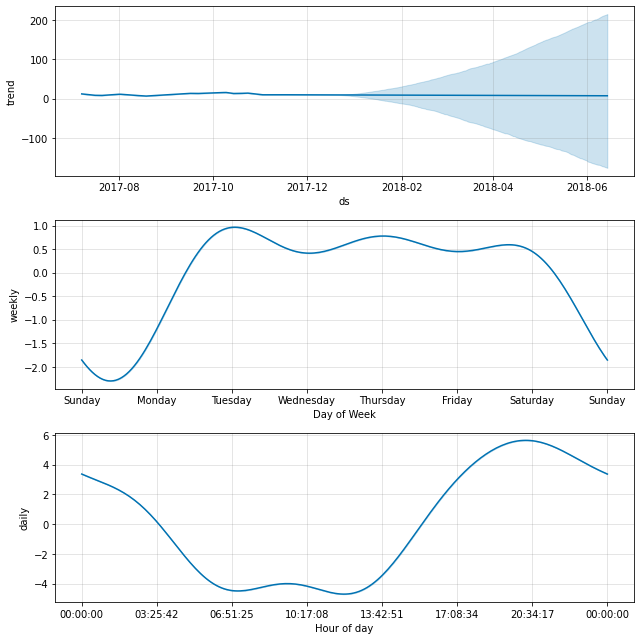

In [42]:
fig2 = prophet_model.plot_components(prophet_forecast)

In [110]:
# so this actually seems pretty similar to the work before even though numbers are different
# let's see if we can do evalution

In [43]:
prophet_forecast_times = prophet_forecast['ds'].transform(pd.Timestamp).rename('time_transformed')


In [44]:
prophet_forecast_times

0       2017-07-07 13:38:29
1       2017-07-07 13:44:13
2       2017-07-07 13:49:47
3       2017-07-07 13:55:16
4       2017-07-07 14:01:03
                ...        
83789   2018-06-14 08:49:19
83790   2018-06-14 08:54:19
83791   2018-06-14 08:59:19
83792   2018-06-14 09:04:19
83793   2018-06-14 09:09:19
Name: time_transformed, Length: 83794, dtype: datetime64[ns]

In [45]:
prophet_forecast_total = prophet_forecast.merge(prophet_forecast_times.to_frame(), left_index = True, right_index = True)

In [46]:
prophet_forecast_total.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed
0,2017-07-07 13:38:29,12.003532,-2.536562,20.406899,12.003532,12.003532,-2.983424,-2.983424,-2.983424,-3.563280,-3.563280,-3.563280,0.579855,0.579855,0.579855,0.0,0.0,0.0,9.020107,2017-07-07 13:38:29
1,2017-07-07 13:44:13,12.001770,-2.237623,20.516504,12.001770,12.001770,-2.844803,-2.844803,-2.844803,-3.425489,-3.425489,-3.425489,0.580687,0.580687,0.580687,0.0,0.0,0.0,9.156967,2017-07-07 13:44:13
2,2017-07-07 13:49:47,12.000059,-2.171291,19.704073,12.000059,12.000059,-2.703739,-2.703739,-2.703739,-3.285212,-3.285212,-3.285212,0.581473,0.581473,0.581473,0.0,0.0,0.0,9.296320,2017-07-07 13:49:47
3,2017-07-07 13:55:16,11.998374,-2.869092,21.261352,11.998374,11.998374,-2.558851,-2.558851,-2.558851,-3.141078,-3.141078,-3.141078,0.582227,0.582227,0.582227,0.0,0.0,0.0,9.439523,2017-07-07 13:55:16
4,2017-07-07 14:01:03,11.996597,-1.154283,21.588128,11.996597,11.996597,-2.399996,-2.399996,-2.399996,-2.982996,-2.982996,-2.982996,0.582999,0.582999,0.582999,0.0,0.0,0.0,9.596601,2017-07-07 14:01:03


In [50]:
compare = prophet_forecast_total.merge(thirty_back, how = 'outer', left_on = 'time_transformed', right_on = 'time_transformed')

In [51]:
compare.head()

,ds_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed,ds_y,y
0,2017-07-07 13:38:29,12.003532,-2.536562,20.406899,12.003532,12.003532,-2.983424,-2.983424,-2.983424,-3.563280,...,0.579855,0.579855,0.579855,0.0,0.0,0.0,9.020107,2017-07-07 13:38:29,NaN,NaN
1,2017-07-07 13:44:13,12.001770,-2.237623,20.516504,12.001770,12.001770,-2.844803,-2.844803,-2.844803,-3.425489,...,0.580687,0.580687,0.580687,0.0,0.0,0.0,9.156967,2017-07-07 13:44:13,NaN,NaN
2,2017-07-07 13:49:47,12.000059,-2.171291,19.704073,12.000059,12.000059,-2.703739,-2.703739,-2.703739,-3.285212,...,0.581473,0.581473,0.581473,0.0,0.0,0.0,9.296320,2017-07-07 13:49:47,NaN,NaN
3,2017-07-07 13:55:16,11.998374,-2.869092,21.261352,11.998374,11.998374,-2.558851,-2.558851,-2.558851,-3.141078,...,0.582227,0.582227,0.582227,0.0,0.0,0.0,9.439523,2017-07-07 13:55:16,NaN,NaN
4,2017-07-07 14:01:03,11.996597,-1.154283,21.588128,11.996597,11.996597,-2.399996,-2.399996,-2.399996,-2.982996,...,0.582999,0.582999,0.582999,0.0,0.0,0.0,9.596601,2017-07-07 14:01:03,NaN,NaN


In [53]:
compare.shape

(161830, 22)

In [56]:
compare['ds_y'].dropna()

32793     2017-12-19T07:09:19
32794     2017-12-19T07:09:19
32795     2017-12-19T07:09:19
32796     2017-12-19T07:09:19
33306     2017-12-21T01:39:19
                 ...         
161825    2018-02-20T19:30:29
161826    2018-02-20T19:56:33
161827    2018-02-20T19:56:33
161828    2018-02-20T19:56:33
161829    2018-02-20T19:56:33
Name: ds_y, Length: 78073, dtype: object

In [60]:
compare_future = compare[33306:]

In [61]:
compare_future.head()

,ds_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed,ds_y,y
33306,2017-12-21 01:39:19,9.409653,1.632198,23.435394,9.391106,9.41784,3.093452,3.093452,3.093452,2.317391,...,0.776061,0.776061,0.776061,0.0,0.0,0.0,12.503105,2017-12-21 01:39:19,2017-12-21T01:39:19,8.403580
33307,2017-12-21 01:39:19,9.409653,1.632198,23.435394,9.391106,9.41784,3.093452,3.093452,3.093452,2.317391,...,0.776061,0.776061,0.776061,0.0,0.0,0.0,12.503105,2017-12-21 01:39:19,2017-12-21T01:39:19,11.897920
33308,2017-12-21 01:39:19,9.409653,1.632198,23.435394,9.391106,9.41784,3.093452,3.093452,3.093452,2.317391,...,0.776061,0.776061,0.776061,0.0,0.0,0.0,12.503105,2017-12-21 01:39:19,2017-12-21T01:39:19,9.058215
33309,2017-12-21 01:39:19,9.409653,1.632198,23.435394,9.391106,9.41784,3.093452,3.093452,3.093452,2.317391,...,0.776061,0.776061,0.776061,0.0,0.0,0.0,12.503105,2017-12-21 01:39:19,2017-12-21T01:39:19,9.158738
33310,2017-12-21 01:39:19,9.409653,1.632198,23.435394,9.391106,9.41784,3.093452,3.093452,3.093452,2.317391,...,0.776061,0.776061,0.776061,0.0,0.0,0.0,12.503105,2017-12-21 01:39:19,2017-12-21T01:39:19,6.647362


In [64]:
compare_future.shape

(128524, 22)

In [66]:
compare_future.loc[:, ['yhat', 'y']]

,yhat,y
33306,12.503105,8.403580
33307,12.503105,11.897920
33308,12.503105,9.058215
33309,12.503105,9.158738
33310,12.503105,6.647362
...,...,...
161825,NaN,17.295782
161826,NaN,11.766633
161827,NaN,0.000000
161828,NaN,11.124949


In [67]:
compare_future_means = compare_future

In [68]:
compare_future_means['yhat'] = compare_future_means['yhat'].fillna(compare_future_means['yhat'].mean())
compare_future_means['y'] = compare_future_means['y'].fillna(compare_future_means['y'].mean())

<ipython-input-68-f8bd2b982ccc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_future_means['yhat'] = compare_future_means['yhat'].fillna(compare_future_means['yhat'].mean())
<ipython-input-68-f8bd2b982ccc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_future_means['y'] = compare_future_means['y'].fillna(compare_future_means['y'].mean())


In [76]:
mse_floor_2 = ((compare_future_means['yhat'] - compare_future_means['y']) ** 2).sum() / compare_future_means.shape[0]

In [77]:
mse_floor_2

50.64062665397791

In [ ]:
# comparing just the unique values for comparison, MSE of 50 isn't actually awful --> let me try with other floors

# Attempt # 3 / Floor 3

In [79]:
floor_3_reduced = floor_3.loc[:, ['time', 'energy']].rename({'time': 'ds', 'energy': 'y'}, axis = 1)

In [80]:
floor_3_reduced['ds'] = floor_3_reduced['ds'].str[0:-6]

In [81]:
floor_3_reduced['time_transformed'] = floor_3_reduced['ds'].transform(pd.Timestamp)

In [82]:
shape_val = floor_3_reduced['time_transformed'].shape[0]

In [83]:
np.round(((0.70) * shape_val))

135447.0

In [84]:
seventy_front = floor_3_reduced.sort_values(by='time_transformed')[0:int(np.round(((0.70) * shape_val)))]
thirty_back = floor_3_reduced.sort_values(by='time_transformed')[int(np.round(((0.70) * shape_val))):]

In [85]:
seventy_front_red = seventy_front.drop(['time_transformed'], axis = 1)
thirty_back_red = thirty_back.drop(['time_transformed'], axis = 1)


In [101]:
seventy_front.tail()

,ds,y,time_transformed
163,2018-09-17T19:59:49,14.589194,2018-09-17 19:59:49
163,2018-09-17T19:59:49,17.530419,2018-09-17 19:59:49
163,2018-09-17T19:59:49,15.748487,2018-09-17 19:59:49
163,2018-09-17T19:59:49,17.170966,2018-09-17 19:59:49
164,2018-09-17T20:06:48,14.723232,2018-09-17 20:06:48


In [87]:
prophet_model = Prophet.Prophet()

In [88]:
prophet_model.fit(seventy_front_red)


17:46:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
prophet_forecast = prophet_model.make_future_dataframe(periods = 51000, freq = '5min')
prophet_forecast = prophet_model.predict(prophet_forecast)

In [90]:
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
84962,2019-03-13 21:46:48,-2.138463,-130.812350,134.394623,-139.708272,124.638557,6.423964,6.423964,6.423964,4.853175,4.853175,4.853175,1.570789,1.570789,1.570789,0.0,0.0,0.0,4.285502
84963,2019-03-13 21:51:48,-2.138658,-136.434204,132.935061,-139.714053,124.640410,6.324639,6.324639,6.324639,4.754718,4.754718,4.754718,1.569921,1.569921,1.569921,0.0,0.0,0.0,4.185981
84964,2019-03-13 21:56:48,-2.138854,-130.534781,131.968637,-139.719835,124.642263,6.225325,6.225325,6.225325,4.656296,4.656296,4.656296,1.569029,1.569029,1.569029,0.0,0.0,0.0,4.086471
84965,2019-03-13 22:01:48,-2.139049,-133.625979,133.264491,-139.725617,124.644116,6.126272,6.126272,6.126272,4.558159,4.558159,4.558159,1.568113,1.568113,1.568113,0.0,0.0,0.0,3.987223
84966,2019-03-13 22:06:48,-2.139244,-131.126320,130.386061,-139.731398,124.645969,6.027723,6.027723,6.027723,4.460549,4.460549,4.460549,1.567173,1.567173,1.567173,0.0,0.0,0.0,3.888478


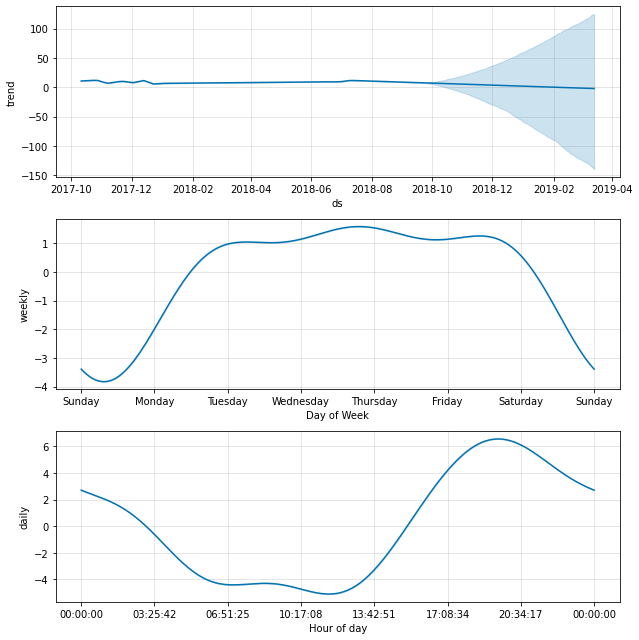

In [92]:
fig3 = prophet_model.plot_components(prophet_forecast)

In [110]:
# so this actually seems pretty similar to the work before even though numbers are different
# let's see if we can do evalution

In [93]:
prophet_forecast_times = prophet_forecast['ds'].transform(pd.Timestamp).rename('time_transformed')


In [94]:
prophet_forecast_times

0       2017-10-11 01:01:16
1       2017-10-11 01:08:05
2       2017-10-11 01:14:51
3       2017-10-11 01:21:43
4       2017-10-11 01:28:32
                ...        
84962   2019-03-13 21:46:48
84963   2019-03-13 21:51:48
84964   2019-03-13 21:56:48
84965   2019-03-13 22:01:48
84966   2019-03-13 22:06:48
Name: time_transformed, Length: 84967, dtype: datetime64[ns]

In [95]:
prophet_forecast_total = prophet_forecast.merge(prophet_forecast_times.to_frame(), left_index = True, right_index = True)

In [96]:
prophet_forecast_total.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed
0,2017-10-11 01:01:16,10.689131,4.616351,23.498623,10.689131,10.689131,3.259841,3.259841,3.259841,2.086403,2.086403,2.086403,1.173438,1.173438,1.173438,0.0,0.0,0.0,13.948972,2017-10-11 01:01:16
1,2017-10-11 01:08:05,10.689641,4.866568,23.983718,10.689641,10.689641,3.188631,3.188631,3.188631,2.012052,2.012052,2.012052,1.176579,1.176579,1.176579,0.0,0.0,0.0,13.878272,2017-10-11 01:08:05
2,2017-10-11 01:14:51,10.690148,4.248373,22.829367,10.690148,10.690148,3.114836,3.114836,3.114836,1.935117,1.935117,1.935117,1.179719,1.179719,1.179719,0.0,0.0,0.0,13.804984,2017-10-11 01:14:51
3,2017-10-11 01:21:43,10.690661,4.211031,22.296477,10.690661,10.690661,3.036209,3.036209,3.036209,1.853281,1.853281,1.853281,1.182928,1.182928,1.182928,0.0,0.0,0.0,13.726871,2017-10-11 01:21:43
4,2017-10-11 01:28:32,10.691171,4.627653,22.542505,10.691171,10.691171,2.953884,2.953884,2.953884,1.767748,1.767748,1.767748,1.186137,1.186137,1.186137,0.0,0.0,0.0,13.645056,2017-10-11 01:28:32


In [97]:
compare = prophet_forecast_total.merge(thirty_back, how = 'outer', left_on = 'time_transformed', right_on = 'time_transformed')

In [98]:
compare.head()

,ds_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed,ds_y,y
0,2017-10-11 01:01:16,10.689131,4.616351,23.498623,10.689131,10.689131,3.259841,3.259841,3.259841,2.086403,...,1.173438,1.173438,1.173438,0.0,0.0,0.0,13.948972,2017-10-11 01:01:16,NaN,NaN
1,2017-10-11 01:08:05,10.689641,4.866568,23.983718,10.689641,10.689641,3.188631,3.188631,3.188631,2.012052,...,1.176579,1.176579,1.176579,0.0,0.0,0.0,13.878272,2017-10-11 01:08:05,NaN,NaN
2,2017-10-11 01:14:51,10.690148,4.248373,22.829367,10.690148,10.690148,3.114836,3.114836,3.114836,1.935117,...,1.179719,1.179719,1.179719,0.0,0.0,0.0,13.804984,2017-10-11 01:14:51,NaN,NaN
3,2017-10-11 01:21:43,10.690661,4.211031,22.296477,10.690661,10.690661,3.036209,3.036209,3.036209,1.853281,...,1.182928,1.182928,1.182928,0.0,0.0,0.0,13.726871,2017-10-11 01:21:43,NaN,NaN
4,2017-10-11 01:28:32,10.691171,4.627653,22.542505,10.691171,10.691171,2.953884,2.953884,2.953884,1.767748,...,1.186137,1.186137,1.186137,0.0,0.0,0.0,13.645056,2017-10-11 01:28:32,NaN,NaN


In [99]:
compare.shape

(142963, 22)

In [100]:
compare['ds_y'].dropna()

33966     2018-09-17T20:06:48
33967     2018-09-17T20:06:48
33968     2018-09-17T20:06:48
34534     2018-09-19T19:16:48
34535     2018-09-19T19:16:48
                 ...         
142958    2019-01-03T01:31:55
142959    2019-01-03T01:38:39
142960    2019-01-03T01:38:39
142961    2019-01-03T01:38:39
142962    2019-01-03T01:38:39
Name: ds_y, Length: 58049, dtype: object

In [102]:
compare_future = compare[34534:]

In [103]:
compare_future.head()

,ds_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed,ds_y,y
34534,2018-09-19 19:16:48,7.713648,6.448989,25.044773,7.713648,7.713648,8.129321,8.129321,8.129321,6.544021,...,1.585300,1.585300,1.585300,0.0,0.0,0.0,15.842969,2018-09-19 19:16:48,2018-09-19T19:16:48,15.567471
34535,2018-09-19 19:16:48,7.713648,6.448989,25.044773,7.713648,7.713648,8.129321,8.129321,8.129321,6.544021,...,1.585300,1.585300,1.585300,0.0,0.0,0.0,15.842969,2018-09-19 19:16:48,2018-09-19T19:16:48,14.050756
34536,2018-09-19 19:16:48,7.713648,6.448989,25.044773,7.713648,7.713648,8.129321,8.129321,8.129321,6.544021,...,1.585300,1.585300,1.585300,0.0,0.0,0.0,15.842969,2018-09-19 19:16:48,2018-09-19T19:16:48,17.145319
34537,2018-09-19 19:16:48,7.713648,6.448989,25.044773,7.713648,7.713648,8.129321,8.129321,8.129321,6.544021,...,1.585300,1.585300,1.585300,0.0,0.0,0.0,15.842969,2018-09-19 19:16:48,2018-09-19T19:16:48,11.915525
34538,2018-09-19 19:21:48,7.713453,6.536044,25.151385,7.713453,7.713453,8.142975,8.142975,8.142975,6.557789,...,1.585186,1.585186,1.585186,0.0,0.0,0.0,15.856428,2018-09-19 19:21:48,NaN,NaN


In [104]:
compare_future.shape

(108429, 22)

In [105]:
compare_future.loc[:, ['yhat', 'y']]

,yhat,y
34534,15.842969,15.567471
34535,15.842969,14.050756
34536,15.842969,17.145319
34537,15.842969,11.915525
34538,15.856428,NaN
...,...,...
142958,NaN,9.651790
142959,NaN,9.594152
142960,NaN,10.045422
142961,NaN,9.476237


In [106]:
compare_future_means = compare_future

In [107]:
compare_future_means['yhat'] = compare_future_means['yhat'].fillna(compare_future_means['yhat'].mean())
compare_future_means['y'] = compare_future_means['y'].fillna(compare_future_means['y'].mean())

<ipython-input-107-f8bd2b982ccc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_future_means['yhat'] = compare_future_means['yhat'].fillna(compare_future_means['yhat'].mean())
<ipython-input-107-f8bd2b982ccc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_future_means['y'] = compare_future_means['y'].fillna(compare_future_means['y'].mean())


In [108]:
mse_floor_3 = ((compare_future_means['yhat'] - compare_future_means['y']) ** 2).sum() / compare_future_means.shape[0]

In [109]:
mse_floor_3

47.75016453897674

# Attempt # 4 / Floor 4

In [110]:
floor_4_reduced = floor_4.loc[:, ['time', 'energy']].rename({'time': 'ds', 'energy': 'y'}, axis = 1)

In [111]:
floor_4_reduced['ds'] = floor_4_reduced['ds'].str[0:-6]

In [112]:
floor_4_reduced['time_transformed'] = floor_4_reduced['ds'].transform(pd.Timestamp)

In [113]:
shape_val = floor_4_reduced['time_transformed'].shape[0]

In [114]:
np.round(((0.70) * shape_val))

120355.0

In [115]:
seventy_front = floor_4_reduced.sort_values(by='time_transformed')[0:int(np.round(((0.70) * shape_val)))]
thirty_back = floor_4_reduced.sort_values(by='time_transformed')[int(np.round(((0.70) * shape_val))):]

In [116]:
seventy_front_red = seventy_front.drop(['time_transformed'], axis = 1)
thirty_back_red = thirty_back.drop(['time_transformed'], axis = 1)


In [117]:
seventy_front.tail()

,ds,y,time_transformed
214,2018-11-16T01:25:25,10.434522,2018-11-16 01:25:25
215,2018-11-16T01:32:24,10.395060,2018-11-16 01:32:24
215,2018-11-16T01:32:24,11.147435,2018-11-16 01:32:24
215,2018-11-16T01:32:24,25.868112,2018-11-16 01:32:24
215,2018-11-16T01:32:24,24.888795,2018-11-16 01:32:24


In [118]:
prophet_model = Prophet.Prophet()

In [119]:
prophet_model.fit(seventy_front_red)


17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:38 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
prophet_forecast = prophet_model.make_future_dataframe(periods = 51000, freq = '5min')
prophet_forecast = prophet_model.predict(prophet_forecast)

In [121]:
prophet_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
75238,2019-05-12 03:12:24,34.051164,-1.695480,59.592158,6.584766,62.869432,-5.557094,-5.557094,-5.557094,-1.885541,-1.885541,-1.885541,-3.671553,-3.671553,-3.671553,0.0,0.0,0.0,28.494069
75239,2019-05-12 03:17:24,34.051571,-2.366180,59.602026,6.584464,62.870786,-5.625685,-5.625685,-5.625685,-1.951217,-1.951217,-1.951217,-3.674468,-3.674468,-3.674468,0.0,0.0,0.0,28.425886
75240,2019-05-12 03:22:24,34.051977,-1.366327,61.337898,6.584161,62.872139,-5.688761,-5.688761,-5.688761,-2.011479,-2.011479,-2.011479,-3.677282,-3.677282,-3.677282,0.0,0.0,0.0,28.363216
75241,2019-05-12 03:27:24,34.052384,-2.505113,59.239314,6.583859,62.873492,-5.746441,-5.746441,-5.746441,-2.066444,-2.066444,-2.066444,-3.679997,-3.679997,-3.679997,0.0,0.0,0.0,28.305943
75242,2019-05-12 03:32:24,34.052791,-3.292533,60.454628,6.583556,62.874846,-5.798873,-5.798873,-5.798873,-2.116262,-2.116262,-2.116262,-3.682611,-3.682611,-3.682611,0.0,0.0,0.0,28.253919


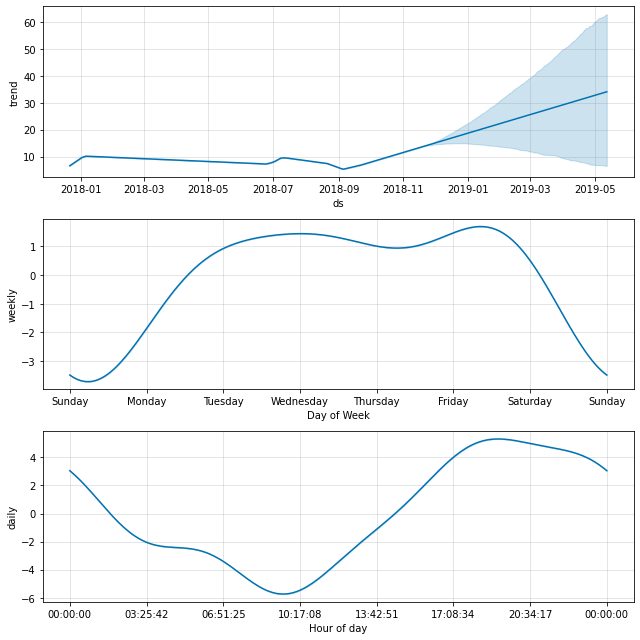

In [122]:
fig4 = prophet_model.plot_components(prophet_forecast)

In [110]:
# so this actually seems pretty similar to the work before even though numbers are different
# let's see if we can do evalution

In [123]:
prophet_forecast_times = prophet_forecast['ds'].transform(pd.Timestamp).rename('time_transformed')


In [124]:
prophet_forecast_times

0       2017-12-21 00:05:48
1       2017-12-21 00:12:18
2       2017-12-21 00:18:59
3       2017-12-21 00:25:42
4       2017-12-21 00:32:19
                ...        
75238   2019-05-12 03:12:24
75239   2019-05-12 03:17:24
75240   2019-05-12 03:22:24
75241   2019-05-12 03:27:24
75242   2019-05-12 03:32:24
Name: time_transformed, Length: 75243, dtype: datetime64[ns]

In [125]:
prophet_forecast_total = prophet_forecast.merge(prophet_forecast_times.to_frame(), left_index = True, right_index = True)

In [126]:
prophet_forecast_total.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed
0,2017-12-21 00:05:48,6.591068,2.308219,19.796048,6.591068,6.591068,3.925933,3.925933,3.925933,2.920595,2.920595,2.920595,1.005338,1.005338,1.005338,0.0,0.0,0.0,10.517001,2017-12-21 00:05:48
1,2017-12-21 00:12:18,6.592288,2.208100,19.054428,6.592288,6.592288,3.768651,3.768651,3.768651,2.765435,2.765435,2.765435,1.003215,1.003215,1.003215,0.0,0.0,0.0,10.360938,2017-12-21 00:12:18
2,2017-12-21 00:18:59,6.593542,2.098242,18.672945,6.593542,6.593542,3.599722,3.599722,3.599722,2.598661,2.598661,2.598661,1.001061,1.001061,1.001061,0.0,0.0,0.0,10.193264,2017-12-21 00:18:59
3,2017-12-21 00:25:42,6.594803,0.762977,18.927032,6.594803,6.594803,3.423035,3.423035,3.423035,2.424111,2.424111,2.424111,0.998924,0.998924,0.998924,0.0,0.0,0.0,10.017838,2017-12-21 00:25:42
4,2017-12-21 00:32:19,6.596045,0.906932,18.064840,6.596045,6.596045,3.242724,3.242724,3.242724,2.245876,2.245876,2.245876,0.996849,0.996849,0.996849,0.0,0.0,0.0,9.838769,2017-12-21 00:32:19


In [127]:
compare = prophet_forecast_total.merge(thirty_back, how = 'outer', left_on = 'time_transformed', right_on = 'time_transformed')

In [128]:
compare.head()

,ds_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed,ds_y,y
0,2017-12-21 00:05:48,6.591068,2.308219,19.796048,6.591068,6.591068,3.925933,3.925933,3.925933,2.920595,...,1.005338,1.005338,1.005338,0.0,0.0,0.0,10.517001,2017-12-21 00:05:48,NaN,NaN
1,2017-12-21 00:12:18,6.592288,2.208100,19.054428,6.592288,6.592288,3.768651,3.768651,3.768651,2.765435,...,1.003215,1.003215,1.003215,0.0,0.0,0.0,10.360938,2017-12-21 00:12:18,NaN,NaN
2,2017-12-21 00:18:59,6.593542,2.098242,18.672945,6.593542,6.593542,3.599722,3.599722,3.599722,2.598661,...,1.001061,1.001061,1.001061,0.0,0.0,0.0,10.193264,2017-12-21 00:18:59,NaN,NaN
3,2017-12-21 00:25:42,6.594803,0.762977,18.927032,6.594803,6.594803,3.423035,3.423035,3.423035,2.424111,...,0.998924,0.998924,0.998924,0.0,0.0,0.0,10.017838,2017-12-21 00:25:42,NaN,NaN
4,2017-12-21 00:32:19,6.596045,0.906932,18.064840,6.596045,6.596045,3.242724,3.242724,3.242724,2.245876,...,0.996849,0.996849,0.996849,0.0,0.0,0.0,9.838769,2017-12-21 00:32:19,NaN,NaN


In [129]:
compare.shape

(126784, 22)

In [131]:
compare['ds_y'].dropna().head(20)

24242    2018-11-16T01:32:24
24249    2018-11-16T02:07:24
24250    2018-11-16T02:07:24
24251    2018-11-16T02:07:24
24252    2018-11-16T02:07:24
24253    2018-11-16T02:07:24
25368    2018-11-19T23:02:24
25369    2018-11-19T23:02:24
25370    2018-11-19T23:02:24
25371    2018-11-19T23:02:24
25372    2018-11-19T23:02:24
25401    2018-11-20T01:27:24
25402    2018-11-20T01:27:24
25403    2018-11-20T01:27:24
25404    2018-11-20T01:27:24
25405    2018-11-20T01:27:24
25604    2018-11-20T18:02:24
25605    2018-11-20T18:02:24
25606    2018-11-20T18:02:24
25607    2018-11-20T18:02:24
Name: ds_y, dtype: object

In [132]:
compare_future = compare[25368:]

In [133]:
compare_future.head()

,ds_x,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,time_transformed,ds_y,y
25368,2018-11-19 23:02:24,13.760374,10.075097,27.234358,13.749549,13.762248,4.905663,4.905663,4.905663,4.035736,...,0.869926,0.869926,0.869926,0.0,0.0,0.0,18.666037,2018-11-19 23:02:24,2018-11-19T23:02:24,18.458044
25369,2018-11-19 23:02:24,13.760374,10.075097,27.234358,13.749549,13.762248,4.905663,4.905663,4.905663,4.035736,...,0.869926,0.869926,0.869926,0.0,0.0,0.0,18.666037,2018-11-19 23:02:24,2018-11-19T23:02:24,20.120482
25370,2018-11-19 23:02:24,13.760374,10.075097,27.234358,13.749549,13.762248,4.905663,4.905663,4.905663,4.035736,...,0.869926,0.869926,0.869926,0.0,0.0,0.0,18.666037,2018-11-19 23:02:24,2018-11-19T23:02:24,10.730146
25371,2018-11-19 23:02:24,13.760374,10.075097,27.234358,13.749549,13.762248,4.905663,4.905663,4.905663,4.035736,...,0.869926,0.869926,0.869926,0.0,0.0,0.0,18.666037,2018-11-19 23:02:24,2018-11-19T23:02:24,34.494898
25372,2018-11-19 23:02:24,13.760374,10.075097,27.234358,13.749549,13.762248,4.905663,4.905663,4.905663,4.035736,...,0.869926,0.869926,0.869926,0.0,0.0,0.0,18.666037,2018-11-19 23:02:24,2018-11-19T23:02:24,34.020137


In [134]:
compare_future.shape

(101416, 22)

In [135]:
compare_future.loc[:, ['yhat', 'y']]

,yhat,y
25368,18.666037,18.458044
25369,18.666037,20.120482
25370,18.666037,10.730146
25371,18.666037,34.494898
25372,18.666037,34.020137
...,...,...
126779,NaN,13.268074
126780,NaN,10.799759
126781,NaN,10.029931
126782,NaN,29.485775


In [136]:
compare_future_means = compare_future

In [137]:
compare_future_means['yhat'] = compare_future_means['yhat'].fillna(compare_future_means['yhat'].mean())
compare_future_means['y'] = compare_future_means['y'].fillna(compare_future_means['y'].mean())

<ipython-input-137-f8bd2b982ccc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_future_means['yhat'] = compare_future_means['yhat'].fillna(compare_future_means['yhat'].mean())
<ipython-input-137-f8bd2b982ccc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_future_means['y'] = compare_future_means['y'].fillna(compare_future_means['y'].mean())


In [139]:
mse_floor_4 = ((compare_future_means['yhat'] - compare_future_means['y']) ** 2).sum() / compare_future_means.shape[0]

In [140]:
mse_floor_4

274.2433927796554

In [ ]:
# ok so this is interesting --> the main one causing issues is the floor 4 data -- we can see this with the trends as well


In [ ]:
# day of the week and time of day trends are pretty similar across 
# But for some reason prophet's struggling with the week 4 data

In [ ]:
#Is there a couple of values that are just really high or that spike after September 2018 to cause this?

This involves mean imputation from the overall column qhich may raise the values or lower them - I can impute with value above or value below as well

Wanted to impute with values from averages but I don't know